# Model for separating project grades from influence of grader

## Short description

Lots of projects. Lots of graders. Each grader, lots of sub-grades. Put them all together in a model

I built this using the outline in this page: [Bayesian Linear Regression Using PyMC3](https://ostwalprasad.github.io/machine-learning/Bayesian-Linear-Regression-using-PyMC3.html)

### Non-colab environment

I ran this under `vscode` using a pixi environment defined in the file `pixi.tom

Installing pixi is a one-liner and I think it's easier ot use than conda / mamba or pip. You can get the installation instructions here: [pixi homepage](https://pixi.sh/latest/)

## Imports and environment setup

In [1]:
# Verify Python environment and package versions
import sys
import chardet
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")

Python version: 3.12.10 | packaged by conda-forge | (main, Apr 10 2025, 22:08:16) [MSC v.1943 64 bit (AMD64)]
NumPy version: 2.2.4
Pandas version: 2.2.3
PyMC version: 5.22.0
ArviZ version: 0.21.0


### Google colab

Since `google colab` always gives you a fresh, clean environment, we need to install only the missing packages. We also clone the repository so we have the data and folders.

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install pymc &> /dev/null
  !pip install xlsxwriter

  from pathlib import Path
  %cd /content
  if not Path("Grades-for-projects-anonymized").is_dir():
    !git clone https://github.com/opherdonchin/Grades-for-projects-anonymized
  %cd /content/Grades-for-projects-anonymized

This is also needed by `colab` for unknown reasons

In [3]:
%env MKL_THREADING_LAYER=GNU

env: MKL_THREADING_LAYER=GNU


### Convert data

In [4]:
# Convert raw talk grades to CSV
import sys, os
# ensure project root is on the Python path
project_root = os.path.abspath(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd())
sys.path.insert(0, project_root)

from src.convert_scores import convert_scores

input_path = os.path.join('data', 'talk grades raw 2025.xlsx')
output_path = os.path.join('data', 'grades talks 2025.csv')

convert_scores(input_path, output_path)
print(f"Saved converted grades to {output_path}")

Converted 129 rows and saved to data\grades talks 2025.csv
Saved converted grades to data\grades talks 2025.csv


### Load data

In [5]:
data_directory = os.path.join('.','data')
base_name = 'talks 2025'
url_raw_data = os.path.join(data_directory, 'grades '+base_name+'.csv')

with open(url_raw_data, 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large

raw_data = pd.read_csv(url_raw_data, encoding = enc['encoding'], sep=",", on_bad_lines='skip')
raw_data['Project'] = raw_data['Project'].astype(int).astype('category')



In [6]:
raw_data.head()

,Project,Judge,Grade
0,1,מאיר פלוטניק,95.0
1,2,מאיר פלוטניק,94.0
2,4,הדר בן יואב,95.0
3,5,הדר בן יואב,90.0
4,6,מאיר פלוטניק,94.0


### Preprocess data

In [7]:
data = raw_data.rename(columns = {'Project':'project', 'Judge':'judge', 'Grade':'grade'})


data['p_idx'], project_cats = pd.factorize(data['project'], sort=True)
data['j_idx'], judge_cats = pd.factorize(data['judge'], sort=True)

print(data.head())
data['grade'].describe()

  project         judge  grade  p_idx  j_idx
0       1  מאיר פלוטניק   95.0      0      8
1       2  מאיר פלוטניק   94.0      1      8
2       4   הדר בן יואב   95.0      2      4
3       5   הדר בן יואב   90.0      3      4
4       6  מאיר פלוטניק   94.0      4      8


count    129.000000
mean      91.790698
std        5.882541
min       72.000000
25%       89.000000
50%       92.000000
75%       96.000000
max      100.000000
Name: grade, dtype: float64

## Model definition and fitting

### Define model

In [8]:
model_name = 'default'
def regression_model(p_idx, j_idx, grade, p_cats, j_cats):
  mu_mu0 = 85
  sd_mu0 = 10
  sd_mus = 10
  # sd_muj = 10
  sd_sd_muj = 7
  sd_sd_g_sigma = 15
  # lambda_j_nu = 1/10

  coords = {"projects": p_cats, "judges": j_cats, "measures":np.arange(len(grade))}
  with pm.Model(coords=coords) as model:
    # Data
    p = pm.Data("project", p_idx, dims=["measures"])
    j = pm.Data("judge", j_idx, dims=["measures"])

    # Priors
    # j_nu = pm.Exponential("j_nu", lam=lambda_j_nu)
    j_nu = pm.ConstantData("j_nu", 2)
    sd_muj = pm.HalfNormal("sd_muj", sigma=sd_sd_muj)
    mu_0 = pm.Normal('mu_0', mu=mu_mu0, sigma=sd_mu0)
    mu_p = pm.Normal('mu_p', mu=0, sigma=sd_mus, dims=["projects"])
    mu_j = pm.StudentT('mu_j', mu=0, sigma=sd_muj, nu=j_nu, dims=["judges"])

    # Regression variables
    g_mu = pm.Deterministic('g_mu', mu_0 + mu_p[p] + mu_j[j], dims=["measures"])
    g_sigma = pm.HalfNormal('g_sigma', sigma=sd_sd_g_sigma)

    # Likelihood
    pm.Normal('g_obs', mu=g_mu, sigma=g_sigma, observed=grade, dims=["measures"])
  return model


### Show model

c:\Repositories\Grades-for-projects-anonymized\.pixi\envs\default\Lib\site-packages\pymc\data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


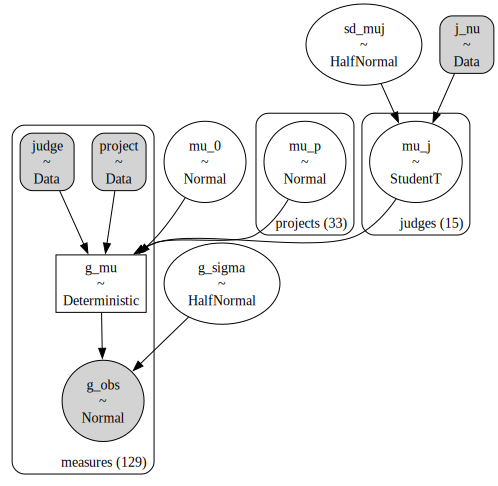

In [9]:
model = regression_model(data.p_idx, data.j_idx, data.grade, project_cats, judge_cats)
pm.model_to_graphviz(model)

### Sample model
Load samples from file if they are already there

In [10]:
trace_path = os.path.join('samples', 'samples ' + base_name + ' ' + model_name)
model_description = f'your model'
if not os.path.isfile(trace_path):
  print(f'Resampling {model_description}')
  model = regression_model(data.p_idx, data.j_idx, data.grade, project_cats, judge_cats)
  with model:
    idata = pm.sample(draws=5000, tune=4000, cores=5, target_accept=0.999, return_inferencedata=True)
  print(f'Saving samples to {trace_path}')
  az.to_netcdf(idata, trace_path)
else:
  print(f'Loading samples for {model_description} from {trace_path}')
  idata = az.from_netcdf(trace_path)



Resampling your model


c:\Repositories\Grades-for-projects-anonymized\.pixi\envs\default\Lib\site-packages\pymc\data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [sd_muj, mu_0, mu_p, mu_j, g_sigma]
NUTS: [sd_muj, mu_0, mu_p, mu_j, g_sigma]


c:\Repositories\Grades-for-projects-anonymized\.pixi\envs\default\Lib\site-packages\rich\live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 5 chains for 4_000 tune and 5_000 draw iterations (20_000 + 25_000 draws total) took 321 seconds.


Saving samples to samples\samples talks 2025 default


## Diagnostics

### Show traces

array([[<Axes: title={'center': 'mu_0'}>,
        <Axes: title={'center': 'mu_0'}>],
       [<Axes: title={'center': 'mu_p'}>,
        <Axes: title={'center': 'mu_p'}>],
       [<Axes: title={'center': 'mu_j'}>,
        <Axes: title={'center': 'mu_j'}>],
       [<Axes: title={'center': 'sd_muj'}>,
        <Axes: title={'center': 'sd_muj'}>],
       [<Axes: title={'center': 'g_sigma'}>,
        <Axes: title={'center': 'g_sigma'}>],
       [<Axes: title={'center': 'g_mu'}>,
        <Axes: title={'center': 'g_mu'}>]], dtype=object)

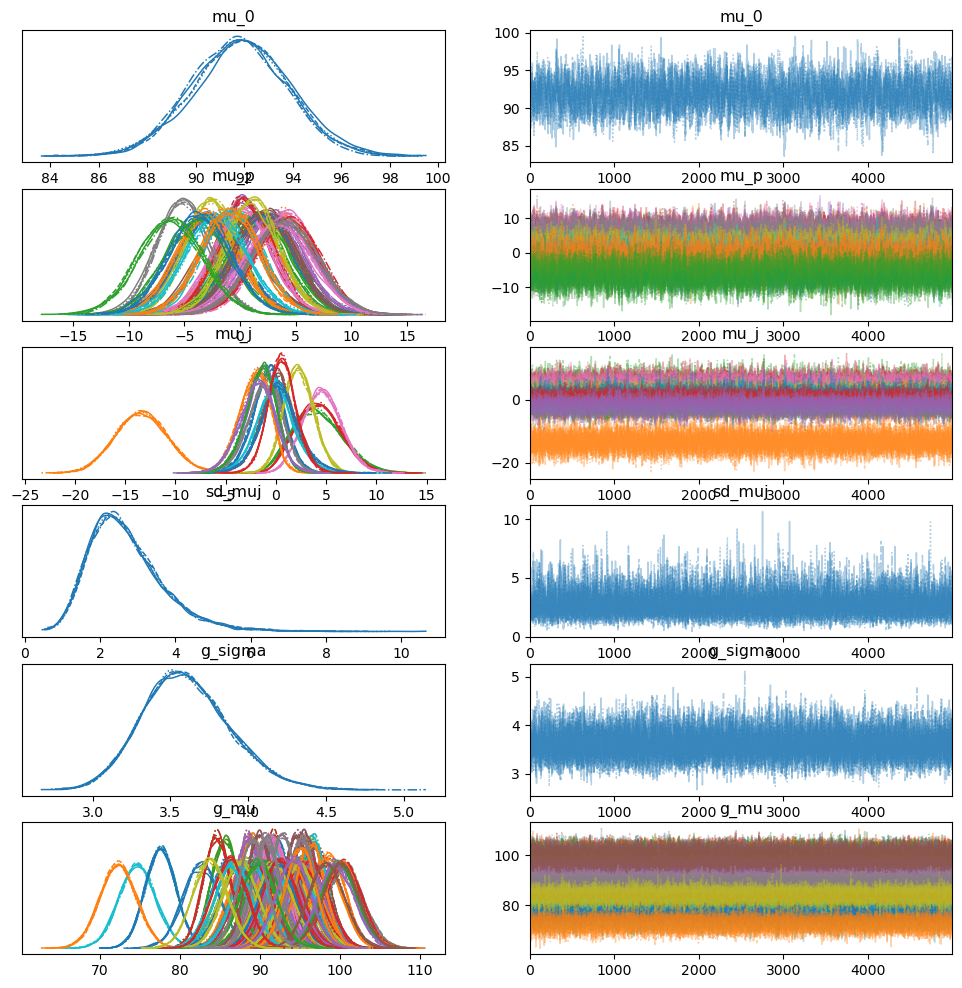

In [11]:
az.plot_trace(idata)

### Plot pairs

In [12]:
post = idata.posterior
keep_judges = [0, 1]
keep_projects = [0, 1]

judge_coords = post.coords['judges']
project_coords = post.coords['projects']

judge_mu_dict = {f'mu_{judge_coords[j].item()}': post['mu_j'][:,:,j] for j in keep_judges}
# judge_s_dict = {f'sd_{judge_coords[j].item()}': post['g_sigma'][:,:,j] for j in keep_judges}
project_dict = {f'mu_{project_coords[p].item()}': post['mu_p'][:,:,p] for p in keep_projects}

plot_data = az.from_dict(
    posterior = {'mu_0': post['mu_0'], 'g_sigma': post['g_sigma'], 'sd_muj': post['sd_muj'], **judge_mu_dict, **project_dict},
    sample_stats = {'diverging': idata.sample_stats.diverging}
)

array([[<Axes: ylabel='g_sigma'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sd_muj'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='mu_אילנה ניסקי'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='mu_אלברטו בילנקה'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='mu_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='mu_0', ylabel='mu_2'>, <Axes: xlabel='g_sigma'>,
        <Axes: xlabel='sd_muj'>, <Axes: xlabel='mu_אילנה ניסקי'>,
        <Axes: xlabel='mu_אלברטו בילנקה'>, <Axes: xlabel='mu_1'>]],
      dtype=object)

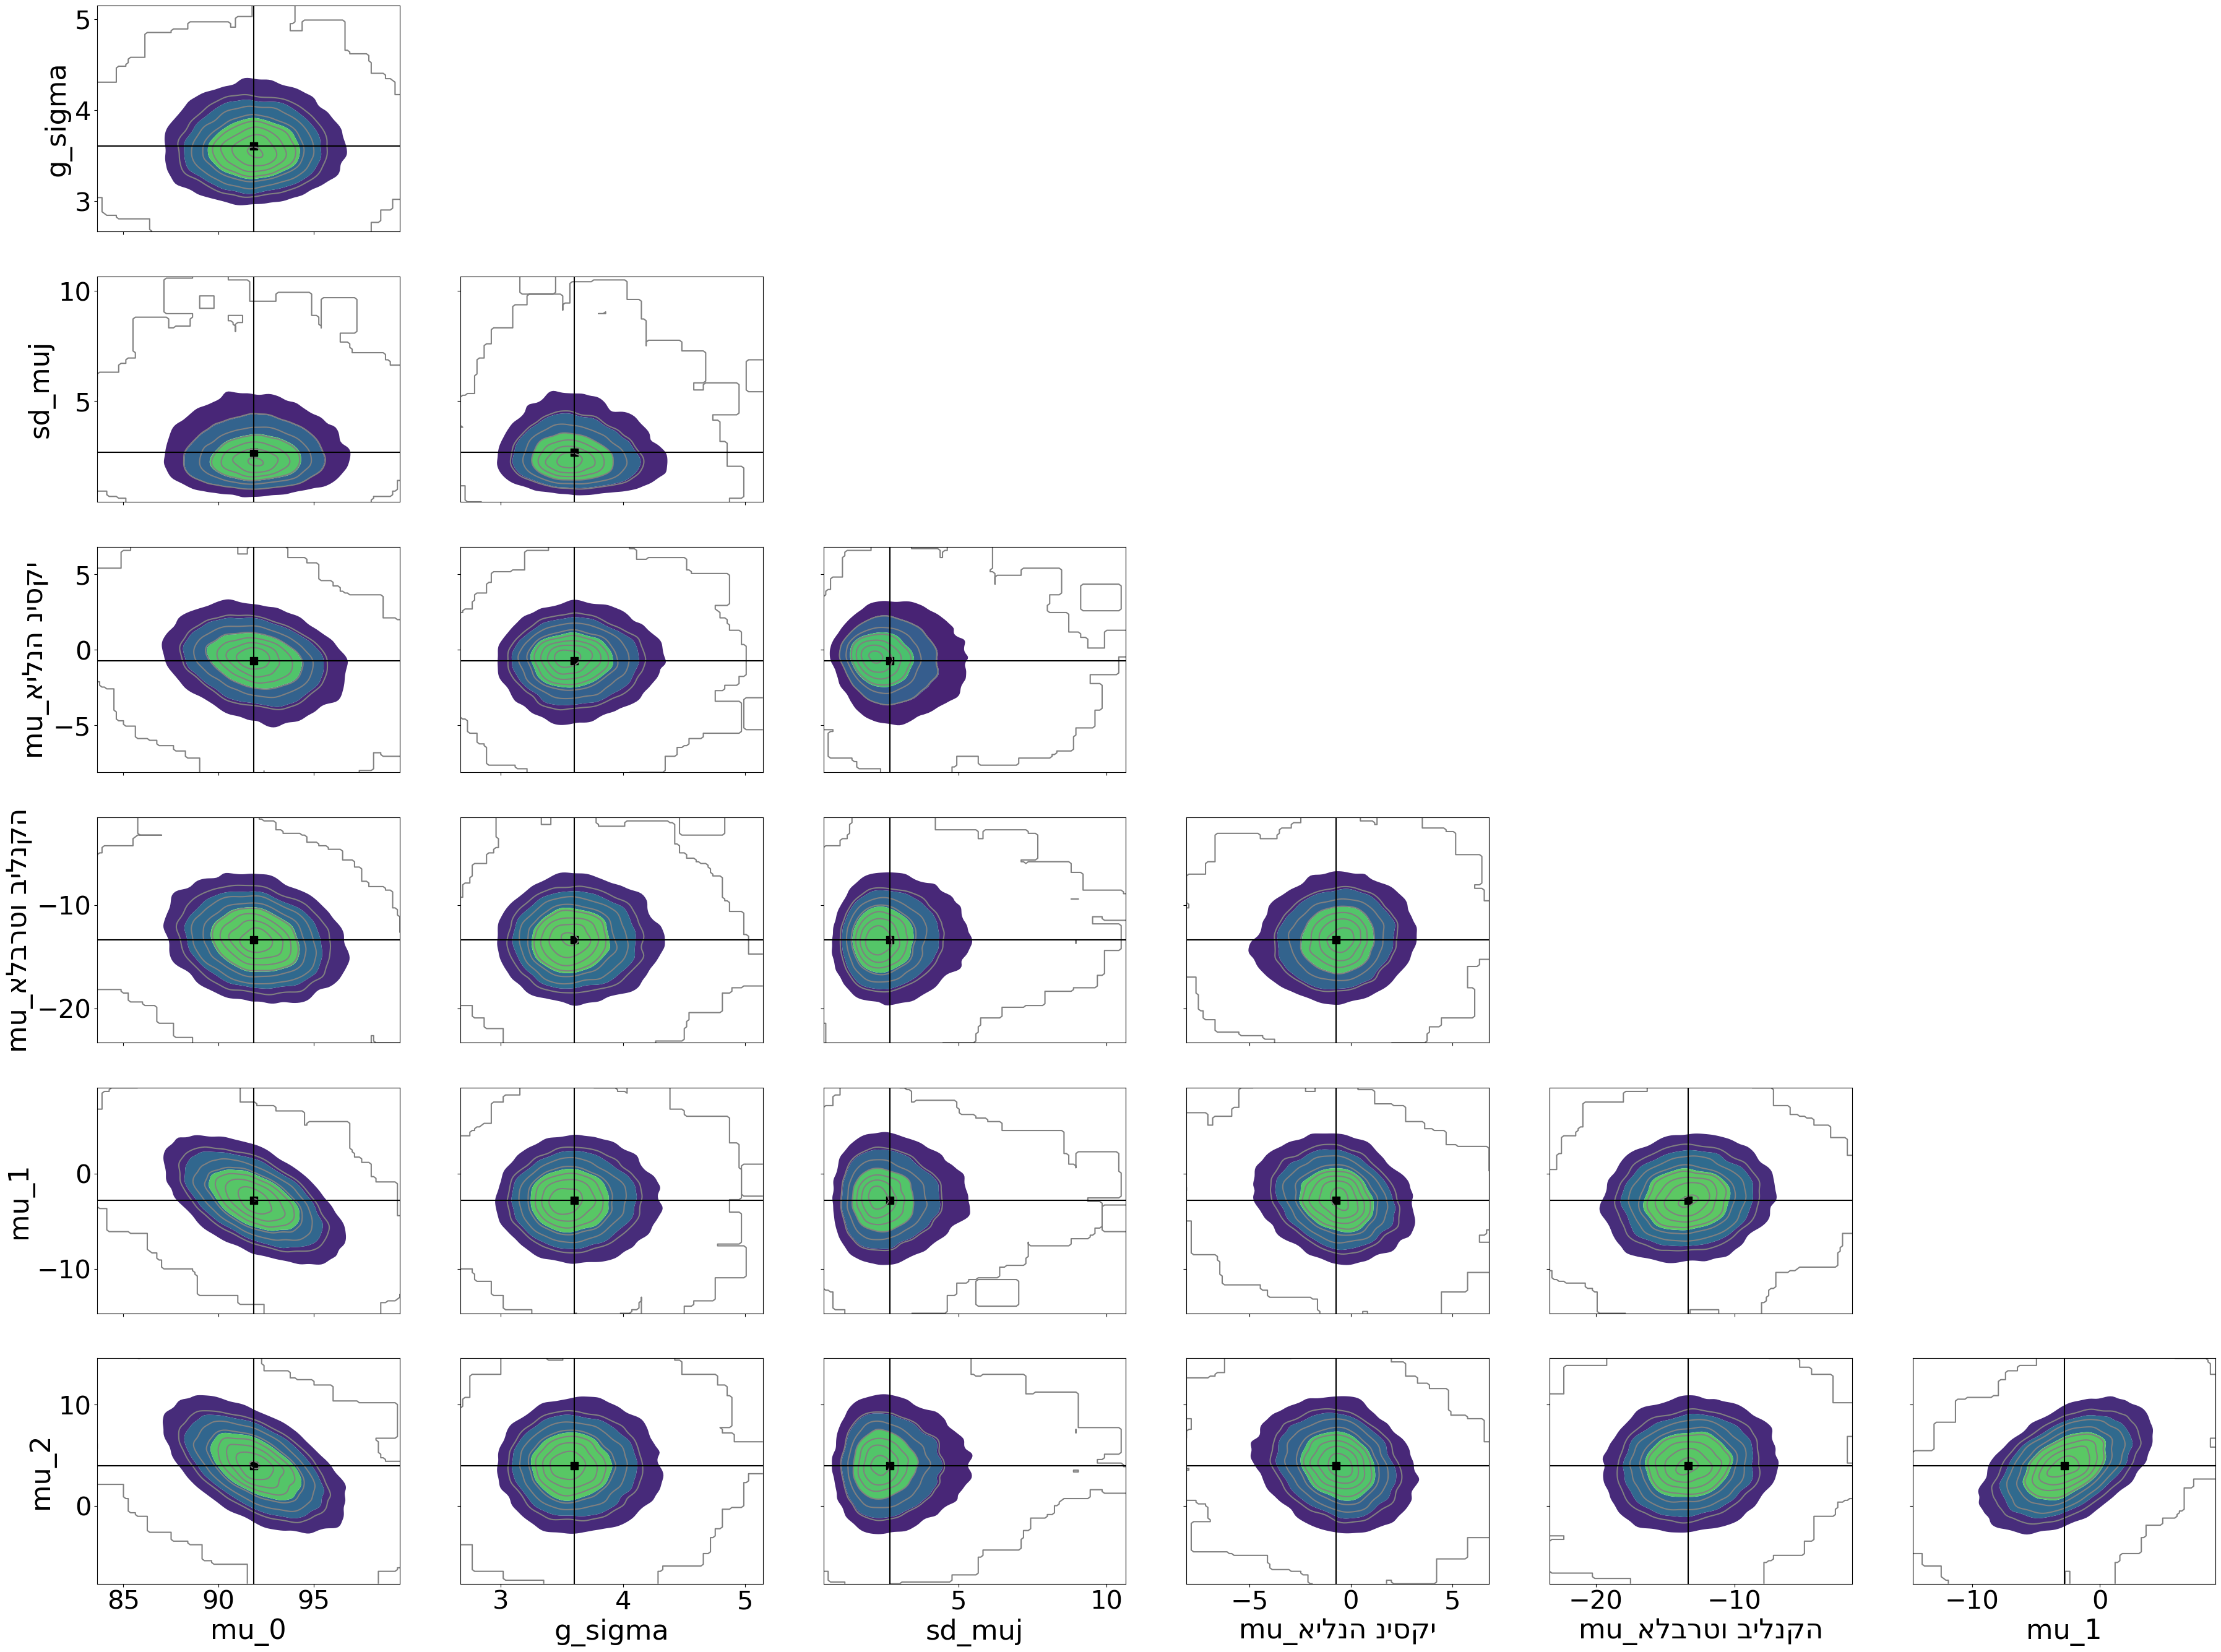

In [14]:
az.plot_pair(plot_data, kind='kde', divergences=True, point_estimate='mean', textsize=30)

## Show results

### Plot judge means and estimates

Text(0.5, 1.0, 'Data mean and corrected value for each judge')

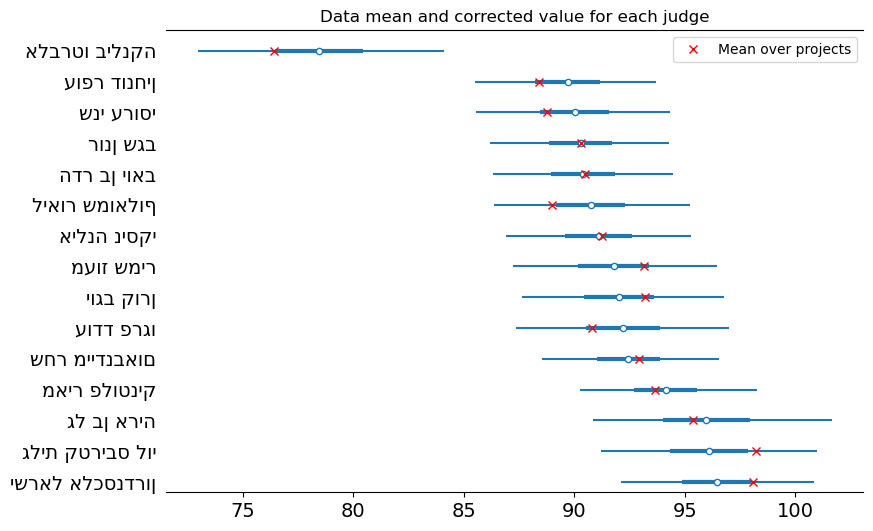

In [15]:
post = idata.posterior
mu_j = post['mu_j']
mu_0 = post['mu_0']

mu_j_mean = mu_j.mean(dim=['chain','draw'])
sort_order = mu_j_mean.argsort()

judge_coords = post.coords['judges']

mu_j_dict = {f'{judge_coords[j.item()].item()}': mu_j[:,:,j]+mu_0 for j in sort_order}

plot_data = az.from_dict(
    posterior = mu_j_dict,
    sample_stats = {'diverging': idata.sample_stats.diverging}
)
ax = az.plot_forest(plot_data, kind='forestplot', combined=True, figsize=[9, 6])

g_data = idata.observed_data.g_obs
j_data = idata.constant_data.judge
xbar_j = [g_data[j_data==j].mean() for j in sort_order.to_numpy()]

y_vals = [li.get_data()[1].item() for li in ax[0].get_lines()]
y_vals = y_vals[::-1]


plt.plot(xbar_j, y_vals, linestyle='None', marker='x', color='r', label='Mean over projects')
ax[0].legend()
ax[0].set_title('Data mean and corrected value for each judge')


### Plot projects means and estimates
There are two ways to do this.

1. Add the estimated mean to the estimated project to get a value that leaves out the judges
2. Subtract the judge mean from the scores to get a corrected score per project

The difference comes fom whether we keep the unexplained variance or discard it. Keeping it will bring up the score of teh worst project and bring
down the score of the best project.

The current plot shows both.

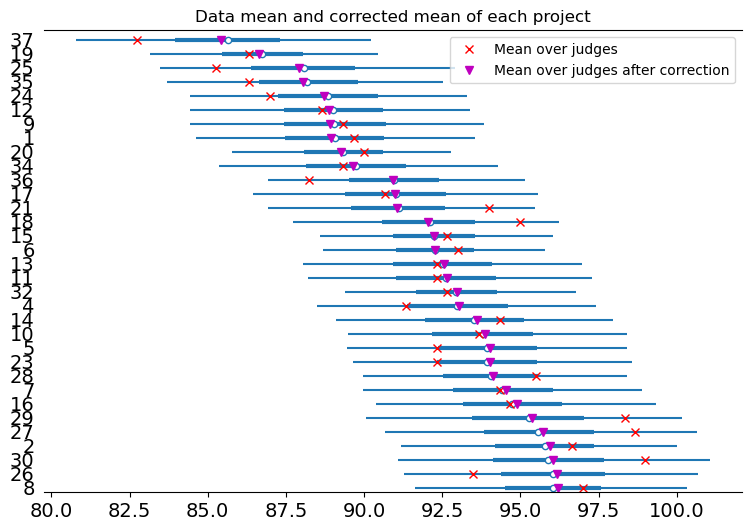

In [16]:
post = idata.posterior
mu_p = post['mu_p']
mu_0 = post['mu_0']

project_coords = post.coords['projects']
reversed_names = [c.item() for c in project_coords]

mu_p_mean = mu_p.mean(dim=['chain','draw'])
sort_order = mu_p_mean.argsort()
mu_p_dict = {f'{reversed_names[p.item()]}': mu_p[:,:,p]+mu_0 for p in sort_order}

plot_data = az.from_dict(
    posterior = mu_p_dict,
    sample_stats = {'diverging': idata.sample_stats.diverging}
)
ax = az.plot_forest(plot_data, kind='forestplot', combined=True, figsize=[9, 6])
ax[0].set_title('Offsets of the different projects')

g_data = idata.observed_data.g_obs
j_data = idata.constant_data.judge
p_data = idata.constant_data.project

xbar_p = [g_data[p_data==p].mean() for p in sort_order.to_numpy()]

g_data_corrected = g_data-mu_j_mean.to_numpy()[j_data]
xbar_p_corrected = [g_data_corrected[p_data==p].mean() for p in sort_order.to_numpy()]

y_vals = [li.get_data()[1].item() for li in ax[0].get_lines()]
y_vals = y_vals[::-1]


plt.plot(xbar_p, y_vals, linestyle='None', marker='x', color='r', label='Mean over judges')
plt.plot(xbar_p_corrected, y_vals, linestyle='None', marker='v', color='m', label='Mean over judges after correction')
ax[0].set_title('Data mean and corrected mean of each project')
ax[0].legend()


### Make a table of the different judges

For each judge, the table will show the projects that they judged along with their grade for that project, then the straight average of all
the judges, then our estimated grade, and finally their grade for this project corrected by our estimated correction for them.

In [ ]:
post = idata.posterior
mu_j = post['mu_j']
sigma_g = post['g_sigma']
mu_p = post['mu_p']
mu_0 = post['mu_0']

mu_j_mean = mu_j.mean(dim=['chain','draw'])
sigma_g_mean = sigma_g.mean(dim=['chain', 'draw'])
mu_p_mean_score = (mu_0 + mu_p).mean(dim=['chain', 'draw'])
sort_order_j = mu_j_mean.argsort()
sort_order_p = mu_p_mean.argsort()

judge_coords = post.coords['judges']
project_coords = post.coords['projects']

g_data = idata.observed_data.g_obs
j_data = idata.constant_data.judge
p_data = idata.constant_data.project

# Data means for judges and projects
xbar_j = [g_data[j_data==j].mean() for j in sort_order_j]
xbar_p = [g_data[p_data==p].mean() for p in np.arange(len(project_coords))]



max_proj = 0
df_rows = list()
titles = ['Judge', 'Correction']
for j_i in sort_order_j:
    j = judge_coords[j_i]
    j_name = judge_coords[j_i].item()
    j_mu = mu_j_mean[j_i].item()
    row = [j_name] # Judge name
    row.append(j_mu)

    for i,p in enumerate(p_data[j_data==j_i]):
        p_i = p.item()
        p_name = project_coords[p_i].item()                      # Project name
        p_bar = xbar_p[p_i].item()                               # Project mean score
        p_j = g_data[np.logical_and(p_data == p_i, j_data == j_i)][0].item()    # Judge score
        p_mu = mu_p_mean_score[p_i].item()                       # Estimates project score
        p_j_corrected = p_j - mu_j_mean[j_i].item()          # Mean score corrected for grader

        row.append(p_name)
        row.append(p_bar)
        row.append(p_j)
        row.append(p_mu)
        row.append(p_j_corrected)
        if len(row) > len(titles):
            titles.append(f'Project {i}')
            titles.append(f'Grade {i}')
            titles.append(f'Judge grade {i}')
            titles.append(f'Estimated {i}')
            titles.append(f'Corrected {i}')

    df_rows.append(row)

grader_table = pd.DataFrame(df_rows, columns=titles)


In [ ]:
grader_table.head()

,Judge,Correction,Project 0,Grade 0,Judge grade 0,Estimated 0,Corrected 0,Project 1,Grade 1,Judge grade 1,...,Project 3,Grade 3,Judge grade 3,Estimated 3,Corrected 3,Project 4,Grade 4,Judge grade 4,Estimated 4,Corrected 4
0,Judge 1,-5.983063,208203521,88.666667,88.0,89.336822,93.983063,315876821,89.000000,89.0,...,205868607,88.000000,68.0,88.429826,73.983063,203677505,85.0,83.0,87.829746,88.983063
1,Judge 11,-5.127676,315490136,82.333333,71.0,82.373526,76.127676,209418813,94.000000,89.0,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
2,Judge 16,-3.714601,205666373,89.333333,79.0,91.220555,82.714601,308159060,80.000000,82.0,...,208788620 & 316406362,90.333333,90.0,89.823612,93.714601,203677505,85.0,79.0,87.829746,82.714601
3,Judge 13,-3.430972,205375215,97.000000,97.0,97.321096,100.430972,208244913,93.666667,90.0,...,318476850,82.000000,64.0,80.740095,67.430972,None,NaN,NaN,NaN,NaN
4,Judge 8,-2.498002,205666373,89.333333,89.0,91.220555,91.498002,206115107,93.333333,90.0,...,205502040 & 311303523,76.333333,77.0,78.158344,79.498002,None,NaN,NaN,NaN,NaN


### Make a table of the different projects

For each project, the table will show the projects straight average and then our estimated score and after that, for each judge the actual score they gave, then
each judges corrected score, and, finally, the average corrected score.

In [ ]:
xbar_j = [g_data[j_data==j].mean() for j in np.arange(len(judge_coords))]
xbar_p = [g_data[p_data==p].mean() for p in np.arange(len(project_coords))]

g_data_corrected = g_data-mu_j_mean.to_numpy()[j_data]
xbar_p_corrected = [g_data_corrected[p_data==p].mean() for p in np.arange(len(project_coords))]

df_rows = list()
titles = ['Project', 'Average', 'Estimated', 'Delta E', 'Corrected', 'Delta C']
for p_i in sort_order_p.to_numpy():
    p = project_coords[p_i]

    p_name = project_coords[p_i].item()
    p_bar = xbar_p[p_i].item()
    p_mu = mu_p_mean_score[p_i].item()
    p_corrected = xbar_p_corrected[p_i].item()

    row = [p_name, p_bar, p_mu, p_mu-p_bar, p_corrected, p_corrected-p_bar] # Judge name

    for i,j in enumerate(j_data[p_data==p_i]):
        j_i = j.item()
        j_name = judge_coords[j_i].item()                      # Judge name
        j_p = g_data[np.logical_and(p_data == p_i, j_data == j_i)][0].item()    # Judge score
        j_p_corrected = j_p - mu_j_mean[j_i].item()          # Mean score corrected for grader

        row.append(j_name)
        row.append(j_p)
        row.append(j_p_corrected)
        if len(row) > len(titles):
            titles.extend([f'Judge {i}', f'Grade {i}', f'Corrected {i}'])

    df_rows.append(row)

project_table = pd.DataFrame(df_rows, columns=titles)


In [ ]:
project_table.head()

,Project,Average,Estimated,Delta E,Corrected,Delta C,Judge 0,Grade 0,Corrected 0,Judge 1,Grade 1,Corrected 1,Judge 2,Grade 2,Corrected 2
0,205502040 & 311303523,76.333333,78.158344,1.825011,76.888527,0.555194,Judge 8,77.0,79.498002,Judge 6,74.0,74.556797,Judge 3,78.0,76.610783
1,208496117,78.666667,78.688773,0.022106,77.519480,-1.147187,Judge 13,77.0,80.430972,Judge 5,68.0,68.398783,Judge 14,91.0,83.728685
2,318476850,82.000000,80.740095,-1.259905,79.845678,-2.154322,Judge 13,64.0,67.430972,Judge 7,90.0,87.377379,Judge 14,92.0,84.728685
3,205883853,83.000000,81.822187,-1.177813,81.068742,-1.931258,Judge 1,71.0,76.983063,Judge 14,91.0,83.728685,Judge 15,87.0,82.494478
4,315490136,82.333333,82.373526,0.040193,81.638997,-0.694336,Judge 11,71.0,76.127676,Judge 10,90.0,87.294838,Judge 15,86.0,81.494478


In [ ]:
with pd.ExcelWriter('tables '+base_name+'.xlsx') as writer:
    grader_table.to_excel(writer, sheet_name='graders', index=False, na_rep='NaN', float_format='%.1f')
    project_table.to_excel(writer, sheet_name='projects', index=False, na_rep='NaN', float_format='%.1f')

    for table, sheet in zip([grader_table, project_table], ['graders', 'projects']):
        for column in table:
            column_length = max(table[column].astype(str).map(len).max(), len(column))
            col_idx = table.columns.get_loc(column)
            writer.sheets[sheet].set_column(col_idx, col_idx, column_length)

    writer.save()


/usr/local/lib/python3.7/dist-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
